In [1]:
import sys
sys.path.append("..")

In [3]:
import configs.default_config as cfg
import configs.remote_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)

ImportError: No module named 'configs'

In [3]:

cfg.SHUFFLE=False

In [158]:
import ipywidgets as widgets
import datetime
import tensorflow as tf
import numpy as np

import dataset_functions
import models.six_stage_linear_model as model
import callbacks
import dataset_builder
import load_weights
import loss_metrics
import utils

In [5]:
import matplotlib.pyplot as plt
import visualizations as v

In [6]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: gs://datasets_bucket_a/training
Retrieving TFrecords from: gs://datasets_bucket_a/validation
Found the following training TFrecords:
 gs://datasets_bucket_a/training-001.tfrecords
gs://datasets_bucket_a/training-002.tfrecords
gs://datasets_bucket_a/training-003.tfrecords
gs://datasets_bucket_a/training-004.tfrecords
gs://datasets_bucket_a/training-005.tfrecords
gs://datasets_bucket_a/training-006.tfrecords
gs://datasets_bucket_a/training-007.tfrecords
gs://datasets_bucket_a/training-008.tfrecords
gs://datasets_bucket_a/training-009.tfrecords
gs://datasets_bucket_a/training-010.tfrecords
gs://datasets_bucket_a/training-011.tfrecords
gs://datasets_bucket_a/training-012.tfrecords
gs://datasets_bucket_a/training-013.tfrecords
gs://datasets_bucket_a/training-014.tfrecords
gs://datasets_bucket_a/training-015.tfrecords
gs://datasets_bucket_a/training-016.tfrecords
gs://datasets_bucket_a/training-017.tfrecords
gs://datasets_bucket_a/training-018.tfrecords
gs://datase

In [43]:
checkpoint="gs://dl_training_results/checkpoints/model1115Sun1219-0341/-E0255.ckpt"

In [44]:
model_maker=model.ModelMaker(cfg) 
tf.keras.backend.clear_session() 
train_model,test_model=model_maker.create_models()
train_model.load_weights(checkpoint)

In [162]:
train_model.save("../trained_models/model11_train-"+utils.now()) 
test_model.save("../trained_models/model11_test-"+utils.now()) 

INFO:tensorflow:Assets written to: ../trained_models/model11_test-15Sun1219-2101/assets


In [29]:
# !rm -r /tmp/model
# !mkdir -p /tmp/model

In [30]:
# model_location="gs://dl_training_results/models/train_model1115Sun1219-0341/"

In [31]:
# !gsutil cp -r {model_location}* /tmp/model/

Copying gs://dl_training_results/models/train_model1115Sun1219-0341/saved_model.pb...
/ [1 files][  5.0 MiB/  5.0 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://dl_training_results/models/train_model1115Sun1219-0341/variables/variables.data-00000-of-00001...
Copying gs://dl_training_results/models/train_model1115Sun1219-0341/variables/variables.index...
\ [3 files][256.8 MiB/256.8 MiB]                                                
Operation completed over 3 objects/256.8 MiB.                                    


In [45]:
# train_model=tf.keras.models.load_model("/tmp/model/")

---
## Dataset input (truth)

In [46]:
#service functions
def remove_mask(inp):
    return inp[...,:-1]
def decmopose_ds_elem(st):
    img=st[0][0][0].numpy()
    paf=st[1][3][0].numpy()
    kpt=st[1][5][0].numpy()
    
    paf=remove_mask(paf)
    kpt=remove_mask(kpt)
    return img,(paf,),(kpt,)

def get_train_model_output(model,st):
    
    img=st[0][0].numpy() #get img from sample tensor
    empty_mask=np.zeros((1,46,46,1)) #generate mask
    inputs=(img,empty_mask) #bundle
    
    pred_t=train_model.predict(inputs) #actual prediction
    
    paf0=remove_mask(pred_t[0])
    paf1=remove_mask(pred_t[1])
    paf2=remove_mask(pred_t[2])
    paf3=remove_mask(pred_t[3])
    kpt0=remove_mask(pred_t[4])
    kpt1=remove_mask(pred_t[5])
    
    return img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)

def extract_single_paf(paf,idx):
    ldim=int(paf.shape[-1]/2)
    return np.stack([paf[...,idx],paf[...,idx+ldim]],axis=-1)

In [69]:
it=iter(dst)

In [143]:
st=next(it)

In [144]:
joint_num=-1#-1 to show all, otherwise joint num to isolate

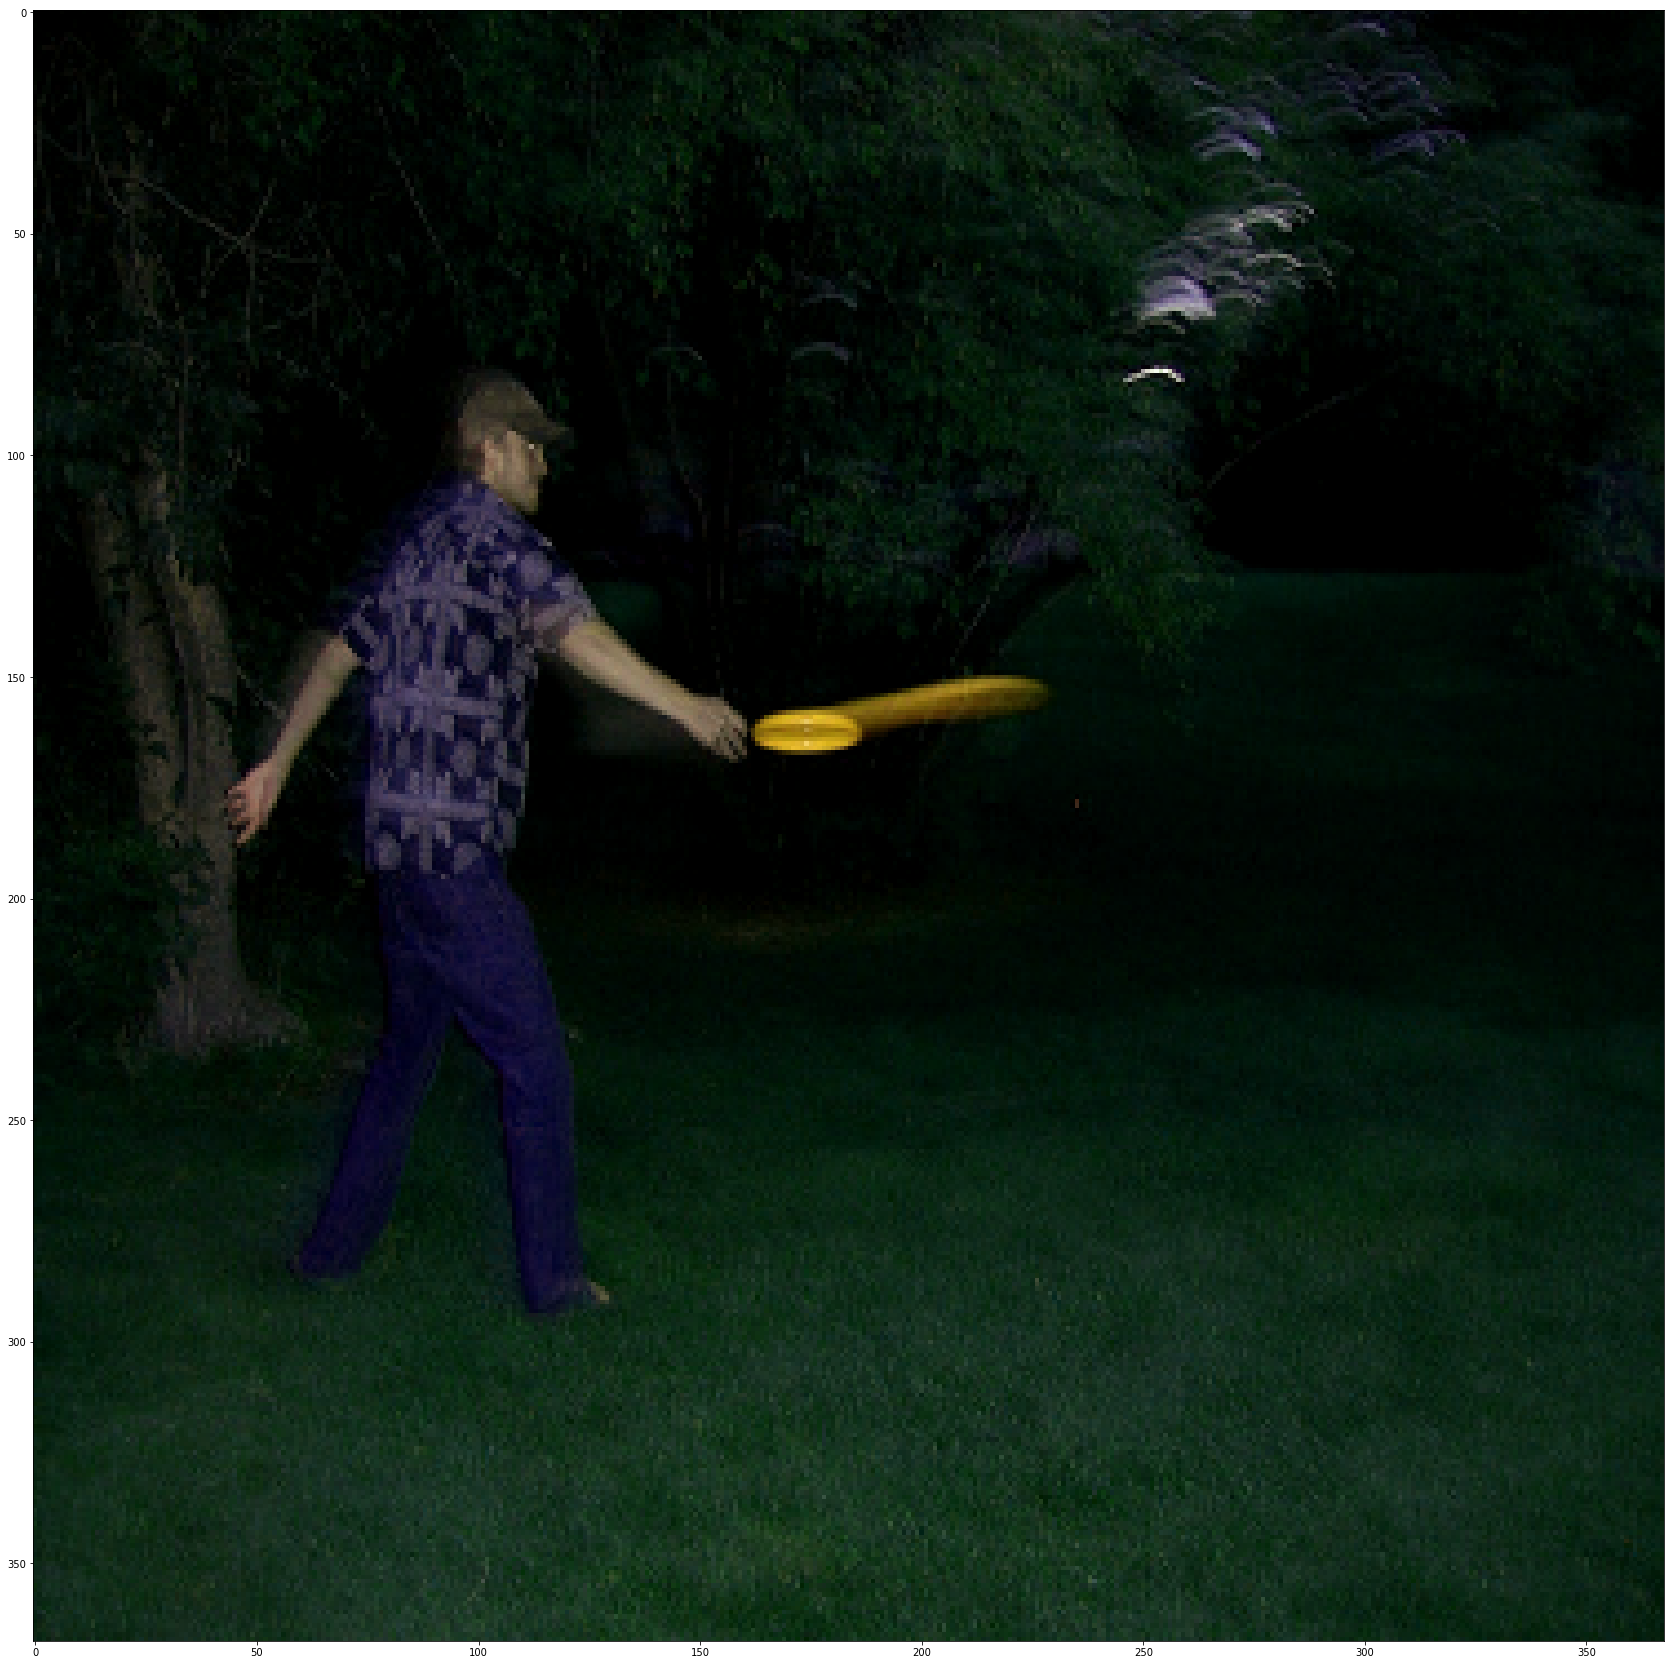

In [145]:
img,(paf,),(kpt,)=decmopose_ds_elem(st)
v.show_img_pafs_kpts(img,None,None,figure_size=30)

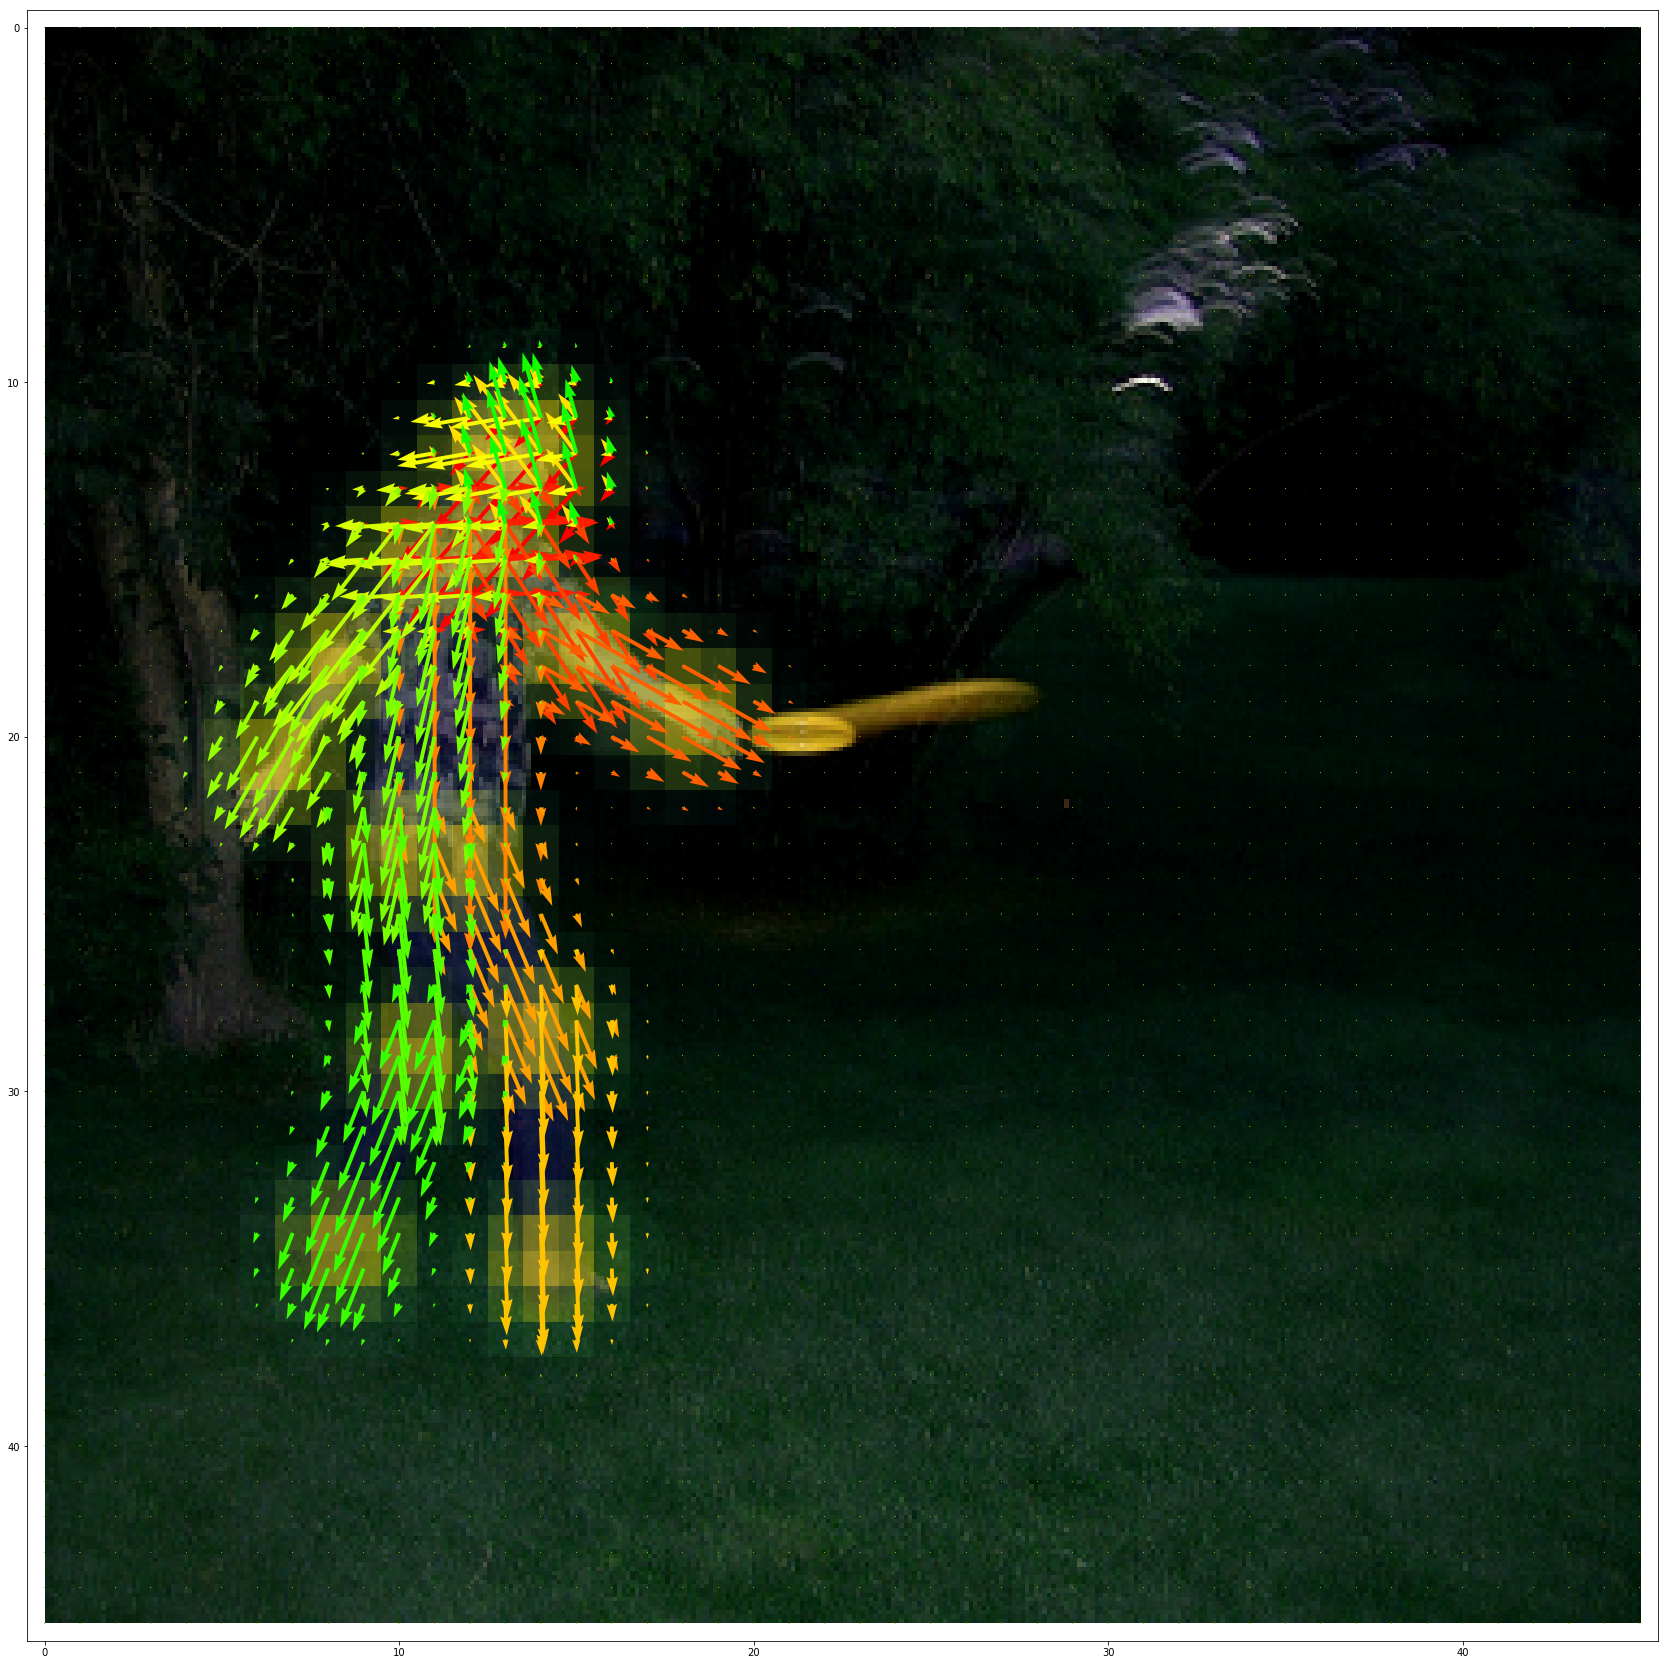

In [146]:
img,(paf,),(kpt,)=decmopose_ds_elem(st)
if joint_num>0:paf=extract_single_paf(paf,joint_num)
if joint_num>0:kpt=kpt[...,x:x+1]
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)

---
## Model prediction

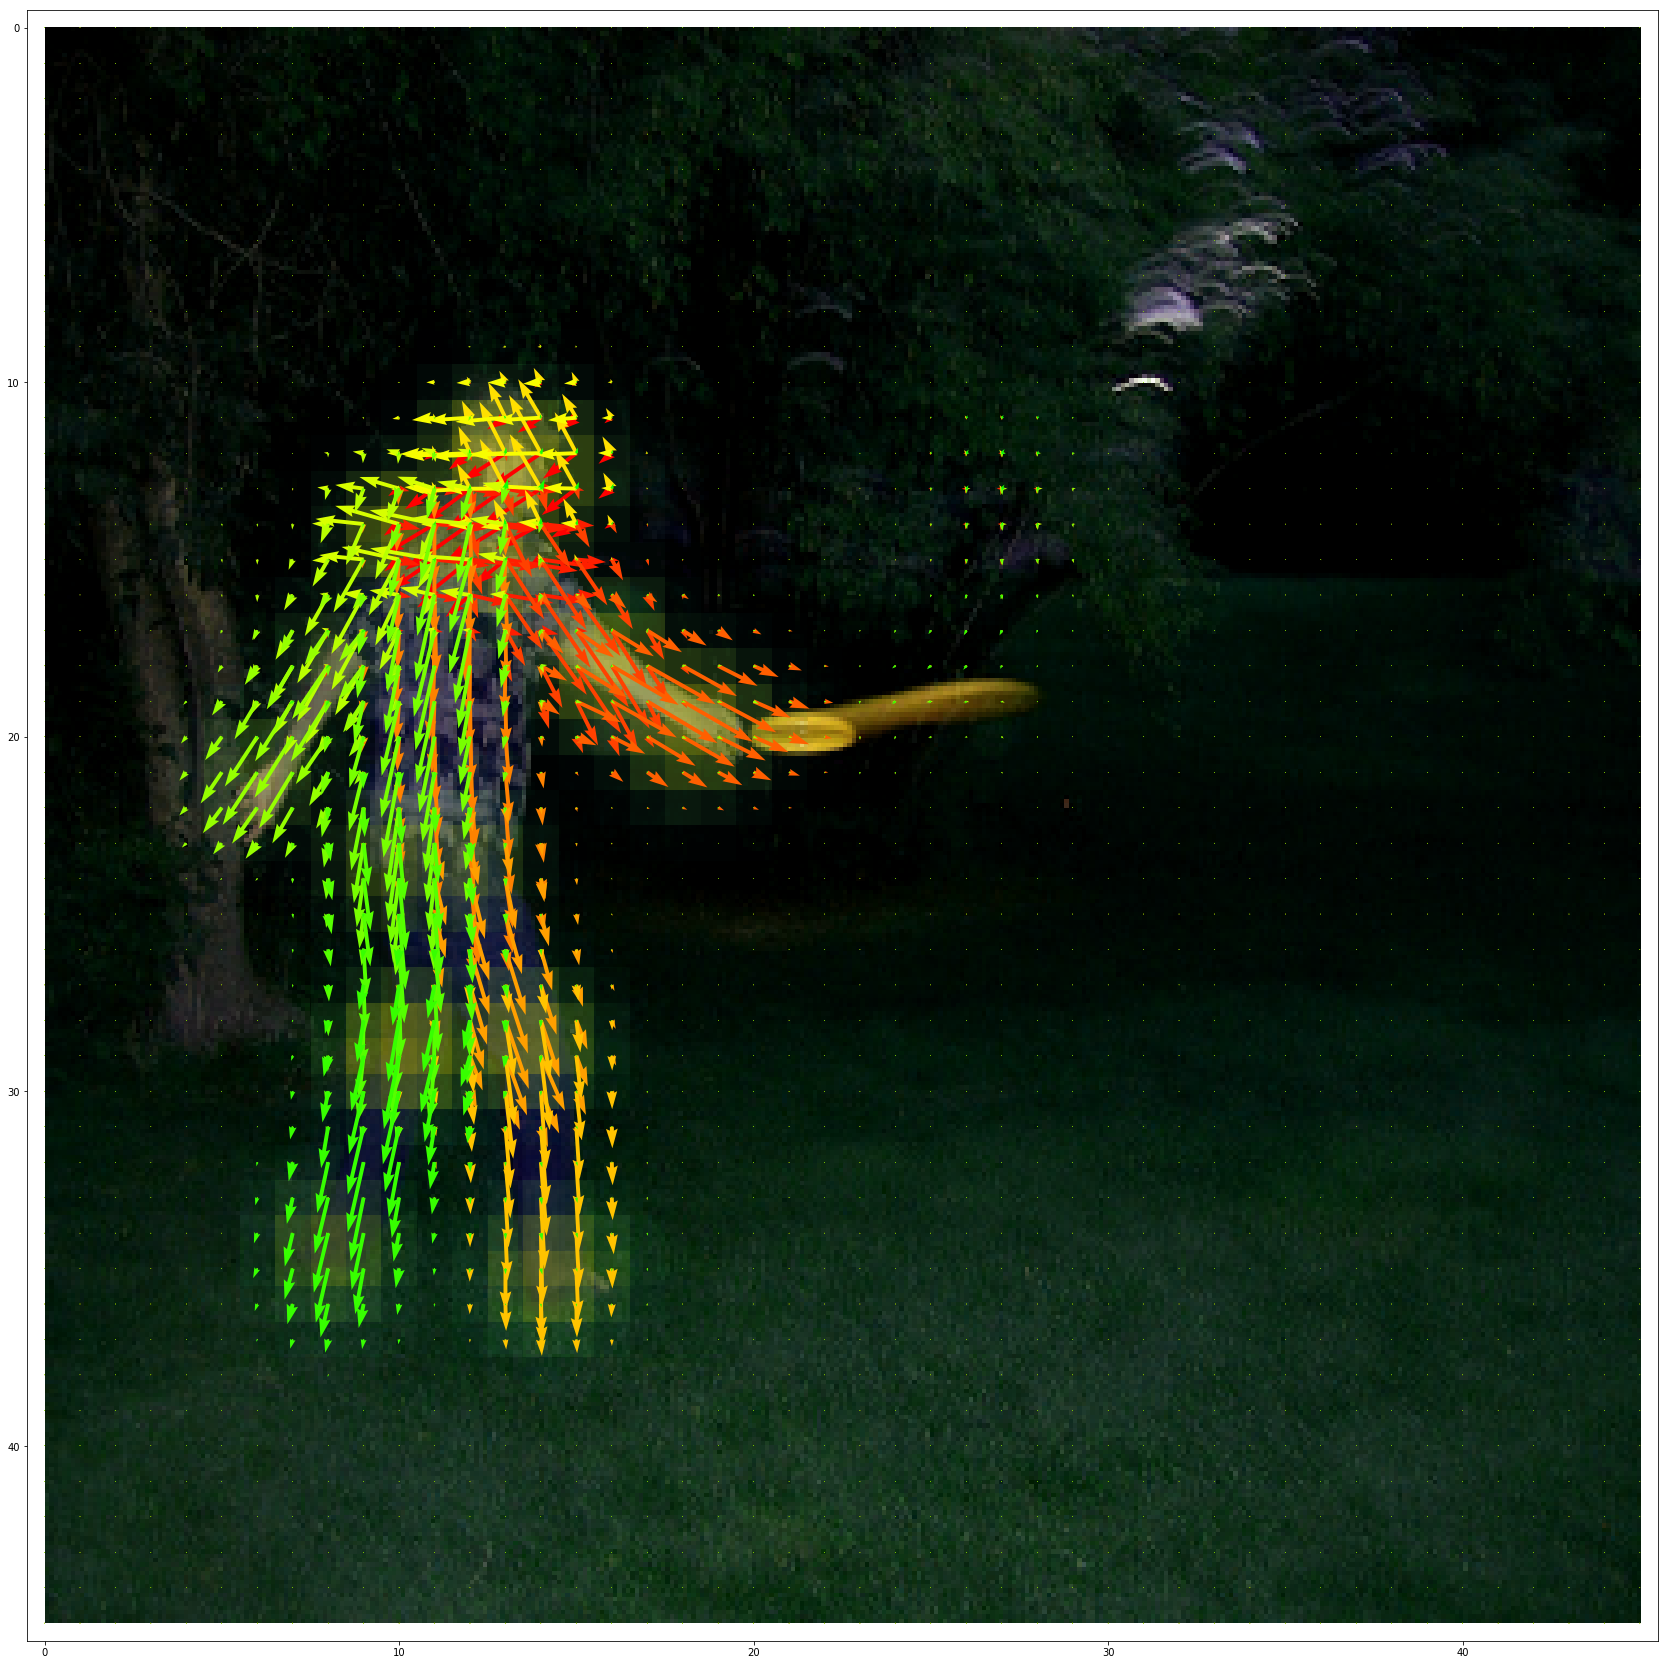

In [147]:
img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)=get_train_model_output(train_model,st)
paf=paf3 #select the outoput to check
kpt=kpt1
if joint_num>0:
    paf=extract_single_paf(paf,joint_num)
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)

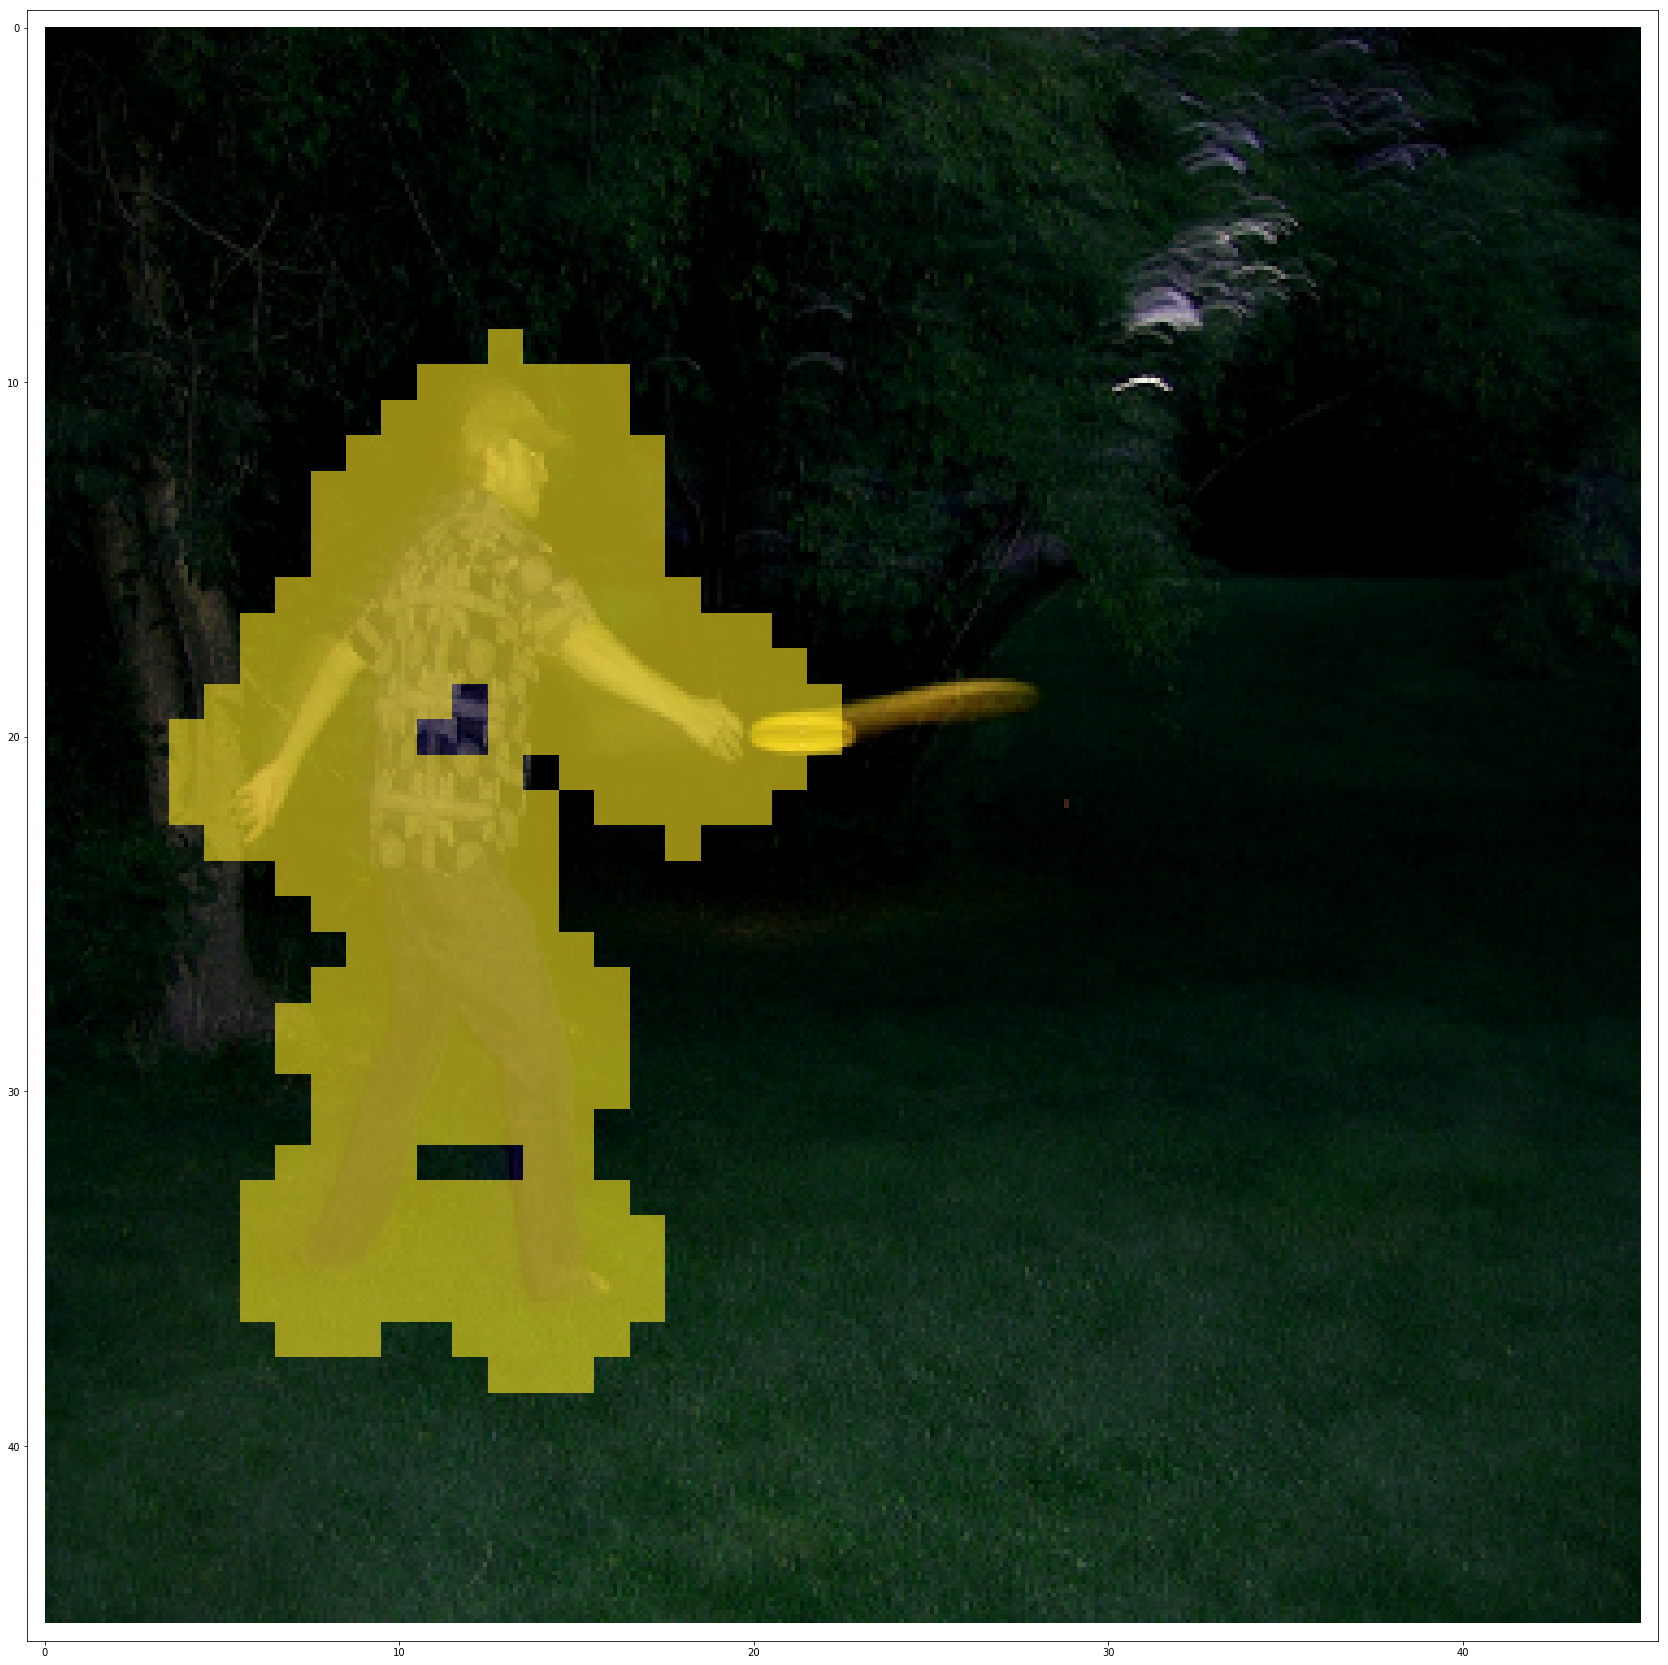

In [148]:
kpt_th=kpt>0.5
v.show_img_pafs_kpts(img,None,kpt_th,figure_size=30)

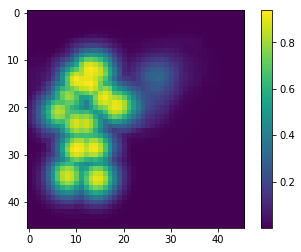

In [155]:
plt.imshow(kpt[0].max(axis=-1))
plt.colorbar()

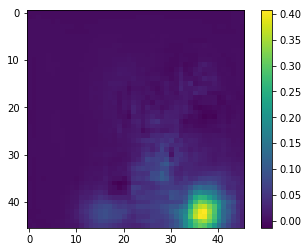

In [125]:
plt.imshow(kpt[0,...,13])
plt.colorbar()

In [157]:
tpaf,tkpt=test_model.predict(img)